In [1]:
%env OMP_NUM_THREADS=1
import firedrake as fd
import numpy as np
import matplotlib.pyplot as plt
from scattering import *
from mesh import *

env: OMP_NUM_THREADS=1


In [2]:
c = 340
d = np.array([1., 0.])
d /= np.linalg.norm(d)
h0 = 0.2

# Sphere

In [3]:
shape = "sphere"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

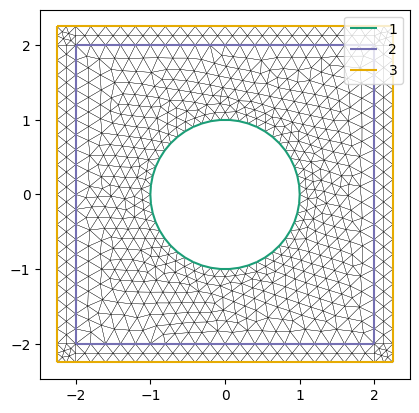

In [4]:
plot_mesh(mesh)

In [5]:
k = 1
omega = k * c
x = fd.SpatialCoordinate(mesh)
inc = fd.exp(1j * fd.dot(fd.as_vector(d), x))
g = -inc

uh = solve(mesh, k, a0, a1, b0, b1, g)

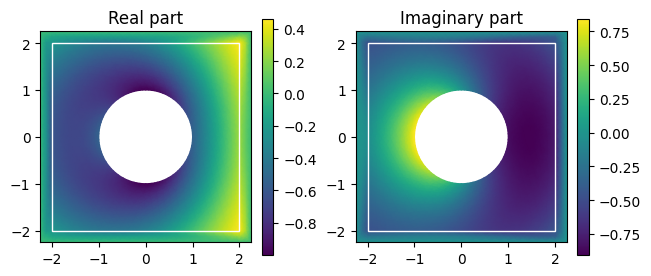

In [6]:
plot_field(uh, a0, a1, b0, b1)

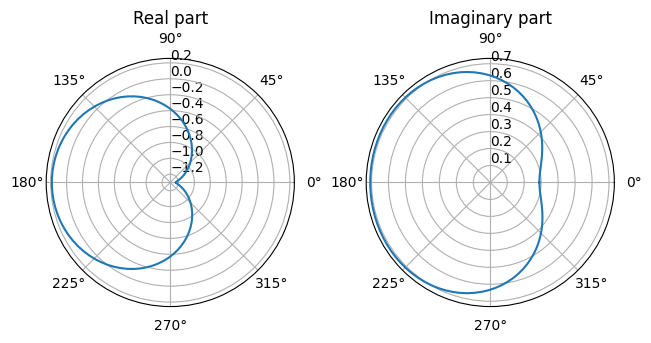

In [7]:
plot_far_field(k, uh, inc)

# Kite

In [8]:
shape = "kite"
a0 = b0 = 2.0
a1 = b1 = 2.25
cached_mesh = True

if cached_mesh:
    mesh = fd.Mesh(shape + str(0) + ".msh")
else:
    mesh = generate_mesh(a0, a1, b0, b1, shape, h0)

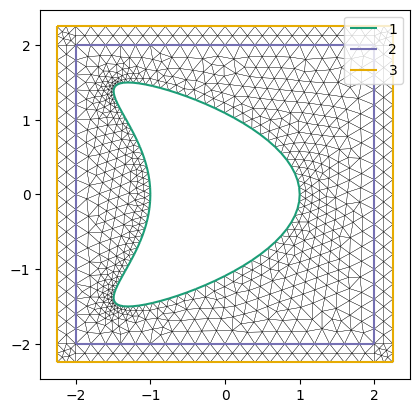

In [9]:
plot_mesh(mesh)

In [10]:
k = 1
omega = k * c
x = fd.SpatialCoordinate(mesh)
inc = fd.exp(1j * fd.dot(fd.as_vector(d), x))
g = -inc

uh = solve(mesh, k, a0, a1, b0, b1, g)

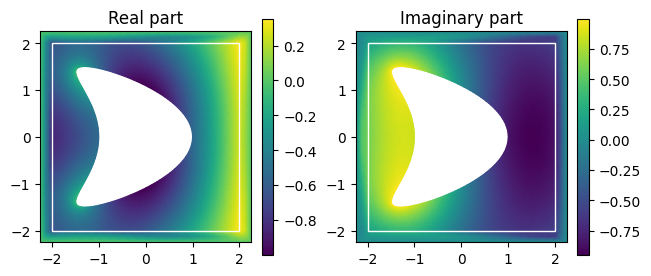

In [11]:
plot_field(uh, a0, a1, b0, b1)

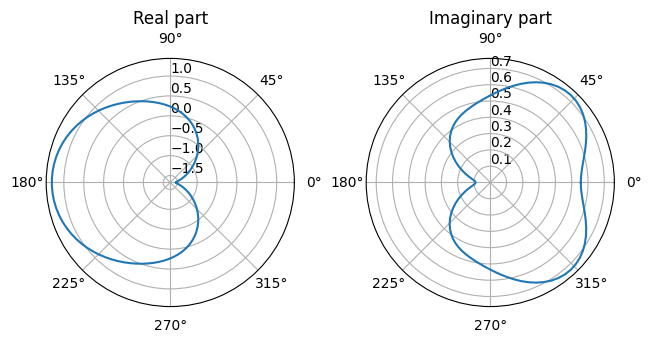

In [12]:
plot_far_field(k, uh, inc)

In [13]:
u_inf = far_field(k, uh, 0, inc)
print("Re{u_inf(d)} =", u_inf.real)
print("Im{u_inf(d)} =", u_inf.imag)

Re{u_inf(d)} = -1.534152338394764
Im{u_inf(d)} = 0.555780867513952


In [14]:
u_inf = far_field(k, uh, np.pi, inc)
print("Re{u_inf(-d)} =", u_inf.real)
print("Im{u_inf(-d)} =", u_inf.imag)

Re{u_inf(-d)} = 1.302787383084972
Im{u_inf(-d)} = 0.08999181719467786


- $Re\{u_\infty(d)\} = −1.62745750, Im\{u_\infty(d)\} = 0.60222591$  
    $Re\{u_\infty(-d)\} = 1.39694488, Im\{u_\infty(-d)\} = 0.09499635$  
    (Colton and Kress - 2019, Table 3.1)

In [15]:
# Convergence
k = 1
max_level = 4
levels = np.arange(max_level)
hs = h0 / 2**levels
if k == 1:
    u_inf_ref = np.array([-1.62745750, 0.60222591, 1.39694488, 0.09499635])
if k == 5:
    u_inf_ref = np.array([-2.47554380, 1.68747937, -0.19945787, 0.06015893])

In [16]:
"""
mesh_hierarchy = []
if cached_mesh:
    for level in levels:
        mesh_hierarchy.append(fd.Mesh(shape + str(level) + ".msh"))
else:
    for level in levels:
        mesh_hierarchy.append(generate_mesh(a0, a1, b0, b1, shape, h0, level))
"""
mesh_hierarchy = fd.MeshHierarchy(mesh, max_level)

k = 1
refinement level 0, relative error [0.05733186 0.07712229 0.06740244 0.05268132]
refinement level 1, relative error [0.02374283 0.03256891 0.03024162 0.08419378]
refinement level 2, relative error [0.01123044 0.01309748 0.01395767 0.01337943]
refinement level 3, relative error [0.00557211 0.00678734 0.00786914 0.06001943]
----------------------------------------


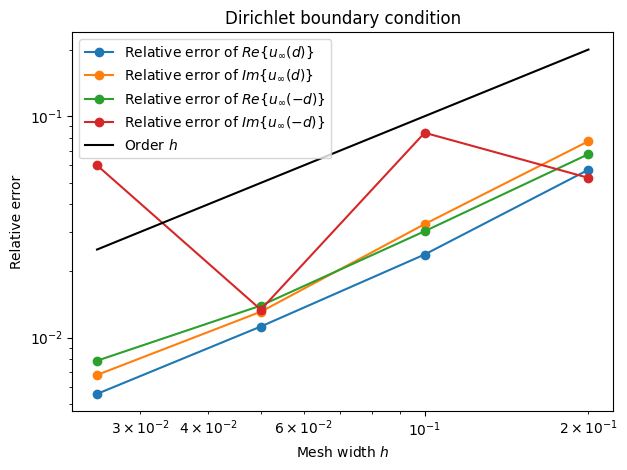

In [17]:
# Dirichlet problem
print(f"k = {k}")
errors = []
for level in levels:
    m = mesh_hierarchy[level]
    x = fd.SpatialCoordinate(m)
    inc = fd.exp(1j * fd.dot(fd.as_vector(d), x))
    g = -inc
    
    uh = solve(m, k, a0, a1, b0, b1, g)

    u_inf = np.empty(4)
    u_inf1 = far_field(k, uh, 0, inc)
    u_inf[0] = u_inf1.real
    u_inf[1] = u_inf1.imag
    u_inf2 = far_field(k, uh, np.pi, inc)
    u_inf[2] = u_inf2.real
    u_inf[3] = u_inf2.imag
    rel_err = np.abs((u_inf - u_inf_ref) / u_inf_ref)
    print(f"refinement level {level}, relative error {rel_err}")
    errors.append(rel_err)
errors = np.array(errors)
plt.loglog(hs, errors[:, 0], "-o",
           label=r"Relative error of $Re\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 1], "-o",
           label=r"Relative error of $Im\{u_\infty(d)\}$")
plt.loglog(hs, errors[:, 2], "-o",
           label=r"Relative error of $Re\{u_\infty(-d)\}$")
plt.loglog(hs, errors[:, 3], "-o",
           label=r"Relative error of $Im\{u_\infty(-d)\}$")
print("----------------------------------------")

plt.loglog(hs, hs, "k", label=r"Order $h$")
plt.legend()
plt.xlabel(r"Mesh width $h$")
plt.ylabel("Relative error")
plt.title("Dirichlet boundary condition")
plt.tight_layout()